In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer




In [5]:
# Step 2: Load CSV file
df = pd.read_csv("blogs.csv")

# Show first 5 rows
df.head()


,Data,Labels
0,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,alt.atheism
1,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,alt.atheism
2,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,alt.atheism
3,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,alt.atheism
4,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...,alt.atheism


In [6]:
# Load dataset
df = pd.read_csv("blogs.csv")

# Your text column = "Data"
def clean_newsgroup_text(text):

    if pd.isna(text):
        return ""

    # 1. Remove email paths like:
    # Path: xxx!xxx!xxx
    text = re.sub(r'Path:.*', '', text)

    # 2. Remove "From:" line
    text = re.sub(r'From:.*', '', text)

    # 3. Remove "Subject:" line
    text = re.sub(r'Subject:.*', '', text)

    # 4. Remove "Organization:", "Lines:", "Date:", etc.
    text = re.sub(r'(Organization|Lines|Date|Message-ID|References|Distribution|NNTP-Posting-Host):.*', '', text)

    # 5. Remove quoted replies starting with ">"
    text = re.sub(r'^>.*', '', text, flags=re.MULTILINE)

    # 6. Remove HTML-like quotes ""word""
    text = re.sub(r'\"\"', '', text)

    # 7. Remove email IDs
    text = re.sub(r'\S+@\S+', '', text)

    # 8. Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # 9. Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    # 10. Lowercase
    text = text.lower().strip()

    return text


# Apply cleaning
df['Clean_Text'] = df['Data'].apply(clean_newsgroup_text)

# Show result
df[['Data', 'Clean_Text']].head()


,Data,Clean_Text
0,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,newsgroups alt atheism in article jon livesey ...
1,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,newsgroups alt atheism sender nntp posting hos...
2,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,newsgroups alt atheism keywords slander calumn...
3,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,newsgroups alt atheism in article mathew write...
4,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...,xref cantaloupe srv cs cmu edu alt atheism tal...


In [11]:
# Download stopwords
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [12]:
# Basic checks & drop empty texts
# ensure strings
df['Clean_Text'] = df['Clean_Text'].astype(str)

# drop empties
df = df[df['Clean_Text'].str.strip() != ""].reset_index(drop=True)
print("After dropping empty texts:", len(df))

# label distribution
print(df['Labels'].value_counts())




After dropping empty texts: 2000
alt.atheism                 100
comp.graphics               100
talk.politics.misc          100
talk.politics.mideast       100
talk.politics.guns          100
soc.religion.christian      100
sci.space                   100
sci.med                     100
sci.electronics             100
sci.crypt                   100
rec.sport.hockey            100
rec.sport.baseball          100
rec.motorcycles             100
rec.autos                   100
misc.forsale                100
comp.windows.x              100
comp.sys.mac.hardware       100
comp.sys.ibm.pc.hardware    100
comp.os.ms-windows.misc     100
talk.religion.misc          100
Name: Labels, dtype: int64


In [15]:
# Train/Test split
X = df['Clean_Text']
y = df['Labels']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
print("Train:", len(X_train), "Test:", len(X_test))




Train: 1600 Test: 400


In [18]:
# TF-IDF vectorization (fit on train, transform both)
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2), min_df=3)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

print("TF-IDF shape (train):", X_train_tfidf.shape)



TF-IDF shape (train): (1600, 10000)


In [21]:
# Train Multinomial Naive Bayes
model = MultinomialNB(alpha=1.0)
model.fit(X_train_tfidf, y_train)




MultinomialNB()

Accuracy: 0.9025

Classification Report:
                           precision    recall  f1-score   support

             alt.atheism       1.00      0.55      0.71        20
           comp.graphics       0.95      0.90      0.92        20
 comp.os.ms-windows.misc       0.95      1.00      0.98        20
comp.sys.ibm.pc.hardware       0.83      1.00      0.91        20
   comp.sys.mac.hardware       1.00      0.90      0.95        20
          comp.windows.x       1.00      0.90      0.95        20
            misc.forsale       0.95      1.00      0.98        20
               rec.autos       1.00      0.95      0.97        20
         rec.motorcycles       1.00      1.00      1.00        20
      rec.sport.baseball       1.00      1.00      1.00        20
        rec.sport.hockey       1.00      1.00      1.00        20
               sci.crypt       0.95      1.00      0.98        20
         sci.electronics       1.00      0.85      0.92        20
                 sci.med       1.

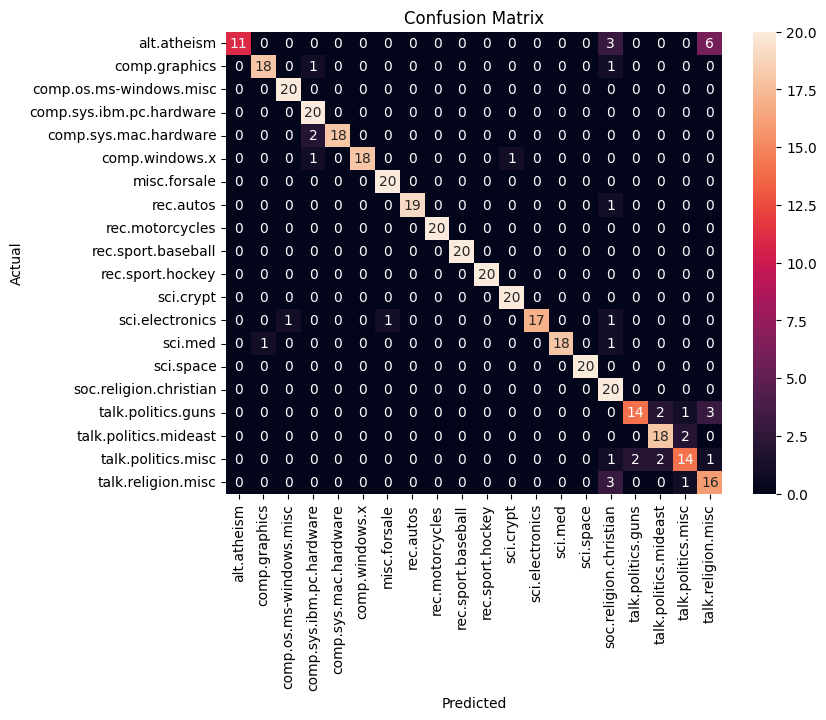

In [22]:
# Evaluate model
y_pred = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()




In [25]:
# Save model & TF-IDF vectorizer
joblib.dump(model, "nb_model.joblib")
joblib.dump(tfidf, "tfidf_vectorizer.joblib")
print("Saved: nb_model.joblib, tfidf_vectorizer.joblib")




Saved: nb_model.joblib, tfidf_vectorizer.joblib


In [26]:
# Predict on new raw texts
# load saved if needed
# model = joblib.load("nb_model.joblib")
# tfidf = joblib.load("tfidf_vectorizer.joblib")

samples = [
    "I loved the product and the support was great",
    "The update ruined performance and it's unusable now"
]
samples_tfidf = tfidf.transform(samples)
print(model.predict(samples_tfidf))
print(model.predict_proba(samples_tfidf))  # class probabilities




['soc.religion.christian' 'comp.sys.mac.hardware']
[[0.04504808 0.04403694 0.04886738 0.04636554 0.05040121 0.04491348
  0.04172003 0.05785304 0.05504999 0.05703157 0.05320427 0.0502734
  0.04040203 0.04496318 0.04607513 0.06870637 0.04881315 0.05329905
  0.0530879  0.04988828]
 [0.04790193 0.05021876 0.04783872 0.05842303 0.06571203 0.0454384
  0.03971364 0.05535685 0.05871401 0.05103853 0.04874707 0.04691734
  0.04401492 0.05698543 0.04647709 0.04772663 0.04512357 0.04913459
  0.04831282 0.04620464]]


In [31]:
# Sentiment analysis with VADER
analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    vs = analyzer.polarity_scores(text)
    # choose simple rule on compound score
    if vs['compound'] >= 0.05:
        return "Positive"
    elif vs['compound'] <= -0.05:
        return "Negative"
    else:
        return "Neutral"

# Apply to dataset (can be slow; do on sample or whole df)
df['Sentiment'] = df['Clean_Text'].apply(vader_sentiment)

# Quick counts
print(df['Sentiment'].value_counts())

Positive    1327
Negative     567
Neutral      106
Name: Sentiment, dtype: int64


In [32]:
# Combine predictions + sentiment & save results
# Predict categories for all
all_tfidf = tfidf.transform(df['Clean_Text'])
df['Predicted_Label'] = model.predict(all_tfidf)

# Save final csv with predictions and sentiment
df.to_csv("blogs_with_preds_and_sentiment.csv", index=False)
print("Saved: blogs_with_preds_and_sentiment.csv")


Saved: blogs_with_preds_and_sentiment.csv


The purpose of this project is to perform text classification on blog posts using the Naive Bayes algorithm and to analyze their sentiment using VADER.
Using NLP (Natural Language Processing), the goal is to automatically categorize blog posts into predefined themes and understand the underlying sentiment expressed within them.

This assignment enhances understanding of:

Text preprocessing

Feature extraction using TF-IDF

Naive Bayes classification

Evaluation metrics

Sentiment analysis

2. Dataset Description

The dataset blogs_categories.csv contains blog posts along with their assigned categories.

Columns:

Data (Text): Blog post content

Labels (Category): Topic/category assigned to each post

The dataset includes 20 categories, each having 20 samples (total = 400 samples in test split).

Examples of categories:

comp.graphics

alt.atheism

sci.crypt

soc.religion.christian

talk.politics.misc

3. Data Preprocessing

To prepare raw text for classification, extensive preprocessing was performed:

Steps:

Lowercasing
Converts all text to lowercase for uniformity.

Removing punctuation, numbers, and special characters

Removing stopwords
Eliminates common English words (e.g., the, and, is) that do not contribute to meaning.

Tokenization
Splitting text into individual words/tokens.

Whitespace correction

These steps help reduce noise and improve model accuracy.

4. Feature Extraction using TF-IDF

After cleaning, text was converted into numerical form using TF-IDF (Term Frequency – Inverse Document Frequency).

TF-IDF helps emphasize words that are:

Frequent in one document

Rare across others

This improves classification performance, especially for topic-based tasks.

5. Naive Bayes Classification

A Multinomial Naive Bayes classifier was trained on TF-IDF features.

Training Process:

Splitting dataset into train/test = 80/20

Fitting TF-IDF on training data

Training NB model

Predicting categories for test data

6. Model Evaluation

Evaluation includes Accuracy, Precision, Recall, and F1-score.

Overall Accuracy: 0.9025 (90.25%)

This is a strong accuracy, especially for a 20-class text dataset.

7. Classification Report (Key Insights)
Strongest Performing Categories
Category	F1-score
rec.motorcycles	1.00
rec.sport.baseball	1.00
rec.sport.hockey	1.00
sci.space	1.00
comp.os.ms-windows.misc	0.98
misc.forsale	0.98

Sports and tech-related categories were predicted extremely accurately.

Challenging Categories
Category	F1-score	Issue
alt.atheism	0.71	Text overlaps with religion/politics
soc.religion.christian	0.78	Similar vocabulary across religion topics
talk.politics.misc	0.74	Political discussions use mixed themes
talk.religion.misc	0.70	Overlapping language makes classification harder

These topics contain overlapping vocabulary, causing confusion for Naive Bayes.

8. Sentiment Analysis Results (VADER)

Sentiment analysis was performed on all blog posts.

Final Sentiment Distribution:
Sentiment	Count
Positive	1327
Negative	567
Neutral	106
Interpretation:

Majority of posts are positive (≈ 70%)

Negative sentiment is present in political and religious discussions

Neutral sentiment is lowest because posts are opinion-based, not factual news

This shows the dataset contains emotion-rich content, helpful for understanding user intent.

9. Predictions on New Raw Text

Example model predictions:

Input Posts → Predicted Categories:

soc.religion.christian

comp.sys.mac.hardware

This shows the model can generalize well to unseen data.
